# Analisis univariante de una serie temporal : Paro en Estados Unidos
    

En este notebook procederemos a realizar el análisis univariante de una serie estocástica , en concreto de la tasa de paro de Estados Unidos en el sector primario. Los datos han sido sacados del FED disponibles en esta página: https://fred.stlouisfed.org/

***

Creamos el entorno de trabajo.

In [41]:
# Librerias de trabajo 

#Manejo de datos
import pandas as pd
from pandas import DatetimeIndex
#Cientifico
from scipy import stats
import math
#Estadisticas 
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.diagnostic as tsa
#Grafico
import matplotlib.pyplot as plt
from statsmodels.graphics.api import qqplot
%matplotlib inline

In [2]:
df = pd.read_excel("fredgraph.xls",skiprows=(14))
columnas = ["fecha","Primario","Transportes","Servicios","Oficina","alto_cargo"]
df.columns = columnas
df.index = DatetimeIndex(df["fecha"])


In [3]:
#comprobamos si hay valores nulos
pd.isnull(df).any()

fecha          False
Primario       False
Transportes    False
Servicios      False
Oficina        False
alto_cargo     False
dtype: bool

In [4]:
df["mean_paro"] = df.mean(axis=1)
df.head()

,fecha,Primario,Transportes,Servicios,Oficina,alto_cargo,mean_paro
fecha,,,,,,,
2000-01-01,2000-01-01,7.3,5.8,5.8,4.3,1.9,5.02
2000-02-01,2000-02-01,7.8,5.7,5.8,4.2,1.7,5.04
2000-03-01,2000-03-01,6.6,5.7,5.8,3.9,1.8,4.76
2000-04-01,2000-04-01,4.8,5.3,4.4,3.7,1.5,3.94
2000-05-01,2000-05-01,4.4,4.8,5.1,4.0,1.6,3.98


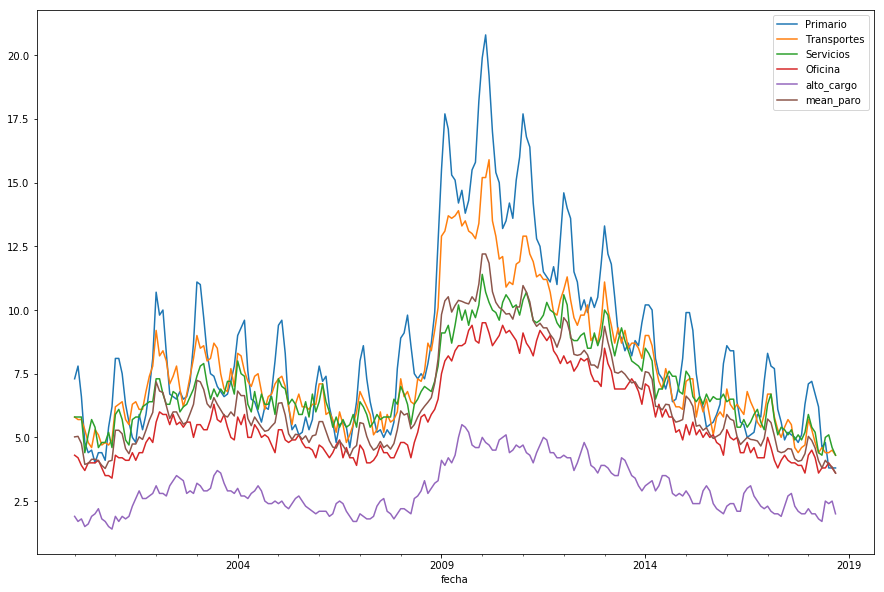

In [5]:
df1 = df[df.columns[1:7]]
df1.plot(legend= True,figsize=(15,10))

In [6]:
# Aplicamos transformacion de Box- Cox
df["ln_Primario"] = df.Primario.apply(math.log)
df["ln_Transportes"]= df.Transportes.apply(math.log)
df["ln_Servicios"] = df.Servicios.apply(math.log)
df["ln_Oficina"]= df.Oficina.apply(math.log)
df["ln_alto_cargo"]= df.alto_cargo.apply(math.log)
df["ln_mean_paro"]= df.mean_paro.apply(math.log)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001B847BBDCF8>,
      dtype=object)

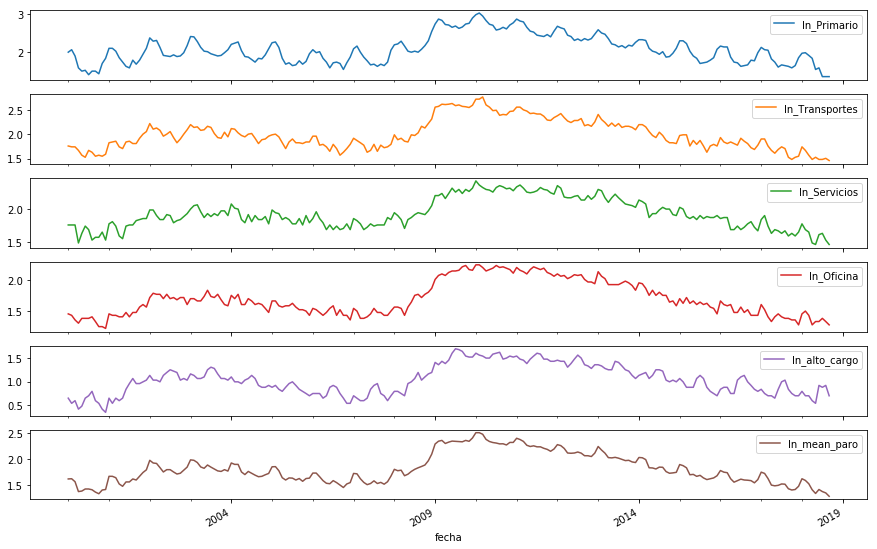

In [7]:
dfln = df[df.columns[7:]]
dfln.plot(legend= True,figsize=(15,10),subplots=True)


In [8]:
# Aplicamos proceso diferencia
df[df.columns[7:]] = df[df.columns[7:]].diff()
df = df.dropna()


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001B847989D68>,
      dtype=object)

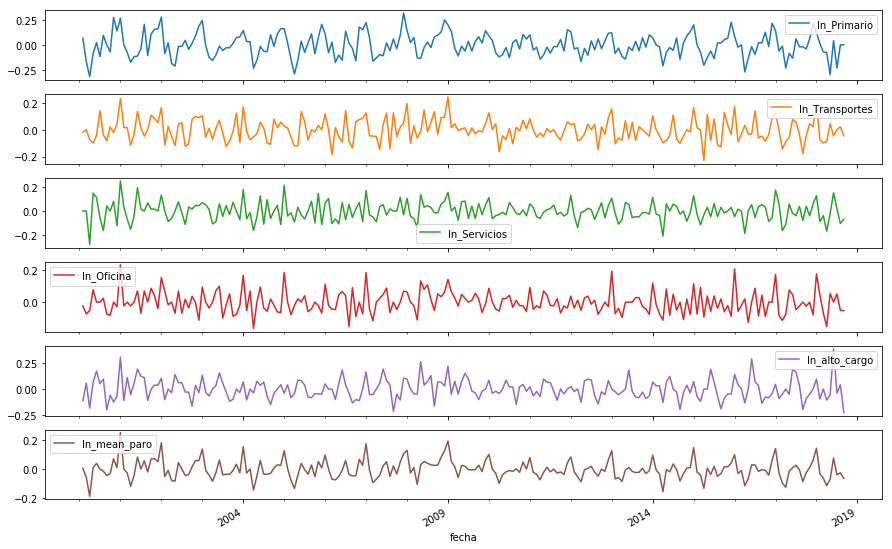

In [9]:
dfest = df[df.columns[7:]]
dfest.plot(legend= True,figsize=(15,10),subplots=True)

Esto lo podriamos interpretar como la tasa de crecimeinto de la tasa de paro segun los distintos sectores.
Podemos apreciar que se mueven de forma bastante parecidas

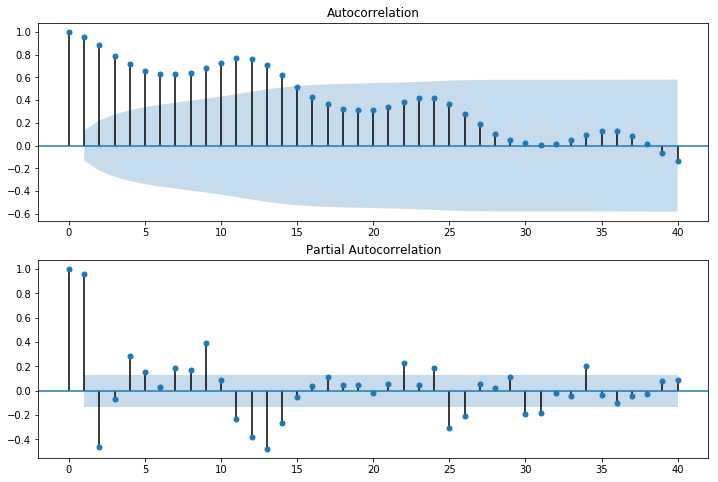

In [10]:
#corelogramas de el ln de Primario, diferenciado 1 periodo
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.Primario, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.Primario, lags=40, ax=ax2)

In [15]:
modelo= sm.tsa.ARMA(df.Primario, order=(2,0) )
arma_res = modelo.fit(disp=True)
print(arma_res.summary())

                              ARMA Model Results                              
Dep. Variable:               Primario   No. Observations:                  224
Model:                     ARMA(2, 0)   Log Likelihood                -290.007
Method:                       css-mle   S.D. of innovations              0.877
Date:                Sun, 14 Oct 2018   AIC                            588.014
Time:                        13:30:24   BIC                            601.661
Sample:                    02-01-2000   HQIC                           593.523
                         - 09-01-2018                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              8.4042      0.997      8.434      0.000       6.451      10.357
ar.L1.Primario     1.3949      0.059     23.477      0.000       1.278       1.511
ar.L2.Primario    -0.4517      0.060

C:\Users\tito-\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


#### Este modelo es estacionario por muy poco, asi que podriamos concluir que no es estacionario.

Pero veamos como se comporta.

In [21]:
df["arma_res"]= arma_res.fittedvalues 
dffit = df[["Primario","arma_res"]]

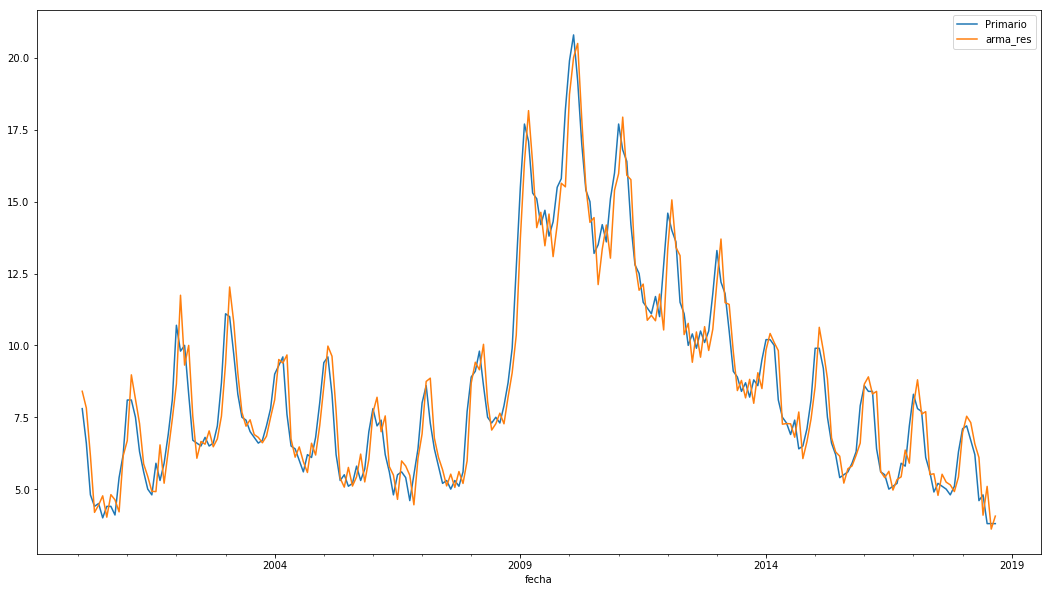

In [22]:
dffit.plot(figsize=(18,10))

In [23]:
resid = arma_res.resid

In [24]:
stats.normaltest(resid)

NormaltestResult(statistic=1.1210381488479408, pvalue=0.5709126407725054)

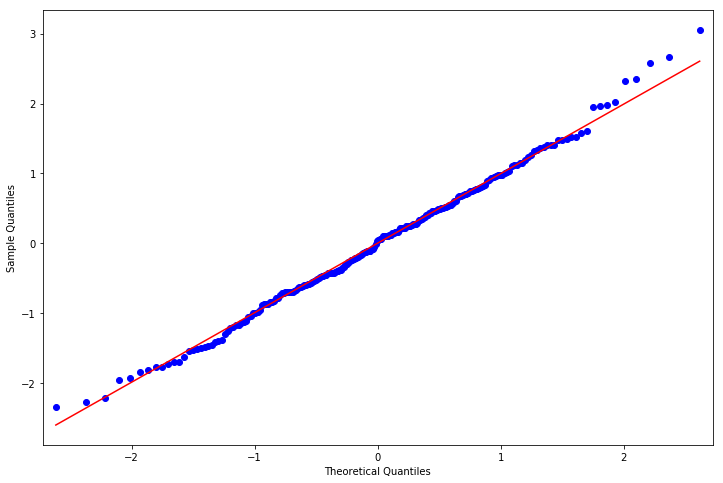

In [25]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(resid, line='q', ax=ax, fit=True)

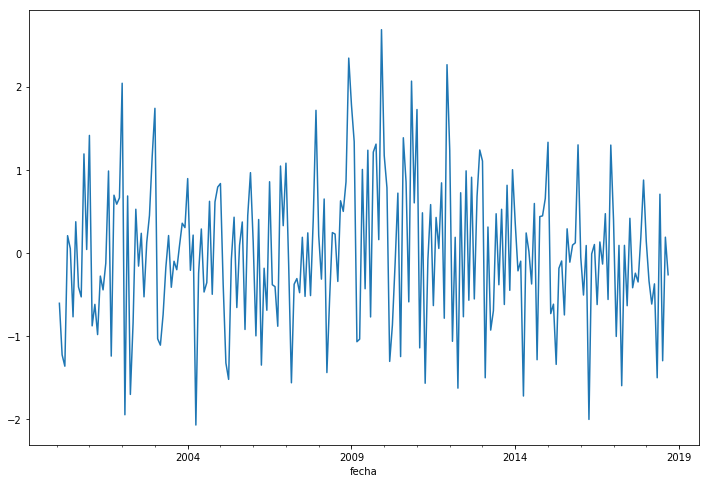

In [26]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax = arma_res.resid.plot(ax=ax)

In [27]:
sm.stats.durbin_watson(arma_res.resid.values)

2.038096683065231

Podemos decir que los errores no tienen correlación

In [43]:
tsa.acorr_ljungbox(arma_res.resid.values, lags=None, boxpierce=True)

(array([9.35169290e-02, 6.29137836e+00, 8.56322570e+00, 1.45587039e+01,
        1.45605792e+01, 1.71462708e+01, 1.82171669e+01, 3.07548839e+01,
        3.16340408e+01, 3.20241559e+01, 5.14377984e+01, 1.03174332e+02,
        1.15990136e+02, 1.17856299e+02, 1.23185147e+02, 1.27285431e+02,
        1.28981785e+02, 1.29188107e+02, 1.29681097e+02, 1.33935705e+02,
        1.42336195e+02, 1.44674585e+02, 1.49828661e+02, 2.10896647e+02,
        2.19536942e+02, 2.19748773e+02, 2.22276493e+02, 2.37097268e+02,
        2.37131195e+02, 2.38843337e+02, 2.39258191e+02, 2.45408815e+02,
        2.54491112e+02, 2.55192402e+02, 2.64053567e+02, 3.03349322e+02,
        3.09423998e+02, 3.10284448e+02, 3.16017356e+02, 3.24553223e+02]),
 array([7.59752834e-01, 4.30372534e-02, 3.56986476e-02, 5.70970876e-03,
        1.24145654e-02, 8.76044633e-03, 1.10276787e-02, 1.55336966e-04,
        2.30306246e-04, 3.96742922e-04, 3.44611435e-07, 1.32686185e-16,
        1.24432592e-18, 1.65263779e-18, 4.55017814e-19, 2.1568

#### Pasemos a la predicción

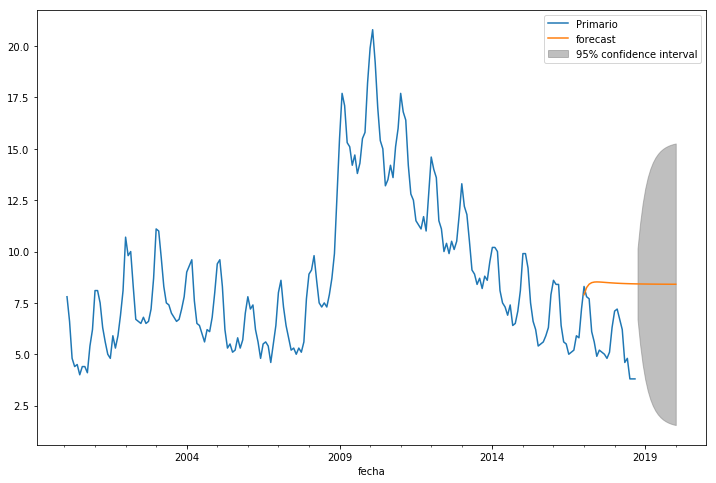

In [28]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = df.Primario.plot(ax=ax)
fig = arma_res.plot_predict('2017', '2020', dynamic=True, ax=ax, plot_insample=False)

Es normal que tengamos esta predicción teneindo encuenta que estamos tratando un ARMA(2,0) o lo que vendria siendo un autorregresivo de orden 2 por lo tanto las prediciones solo serian "fiables" para dos perodos hacia adelante. 

***


### Pasemos ahora a un modelo ARIMA 

Esto seria un procero ARMA aplicado a la difresncia $\Delta{X_t}$ esto lo podriamos interpretar a la practica como un modelo que defina la tasa de variacíon de la tasa de paro del sector primario en USA.

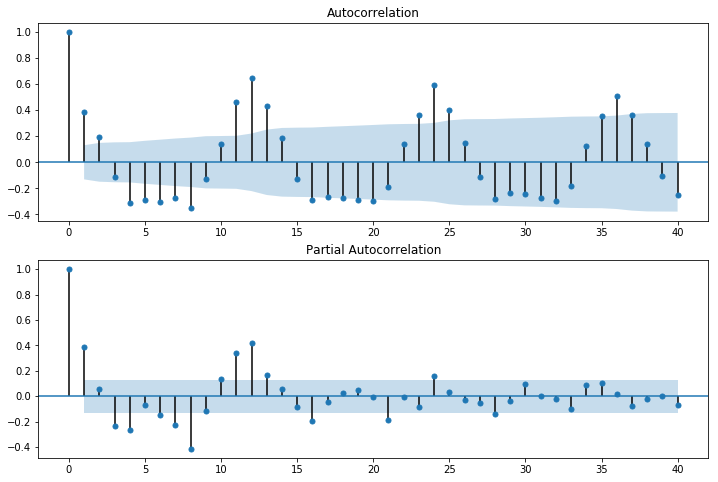

In [29]:
#corelogramas de el ln de Primario, diferenciado 1 periodo
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.ln_Primario, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.ln_Primario, lags=40, ax=ax2)

In [30]:
modelo2= sm.tsa.ARMA(df.ln_Primario, order=(2,0))
arma_res2 = modelo2.fit(disp=True)
print(arma_res2.summary())

                              ARMA Model Results                              
Dep. Variable:            ln_Primario   No. Observations:                  224
Model:                     ARMA(2, 0)   Log Likelihood                 180.819
Method:                       css-mle   S.D. of innovations              0.108
Date:                Sun, 14 Oct 2018   AIC                           -353.637
Time:                        13:32:54   BIC                           -339.991
Sample:                    02-01-2000   HQIC                          -348.129
                         - 09-01-2018                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0028      0.012     -0.225      0.822      -0.027       0.021
ar.L1.ln_Primario     0.3616      0.067      5.416      0.000       0.231       0.492
ar.L2.ln_Primario     0.

C:\Users\tito-\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


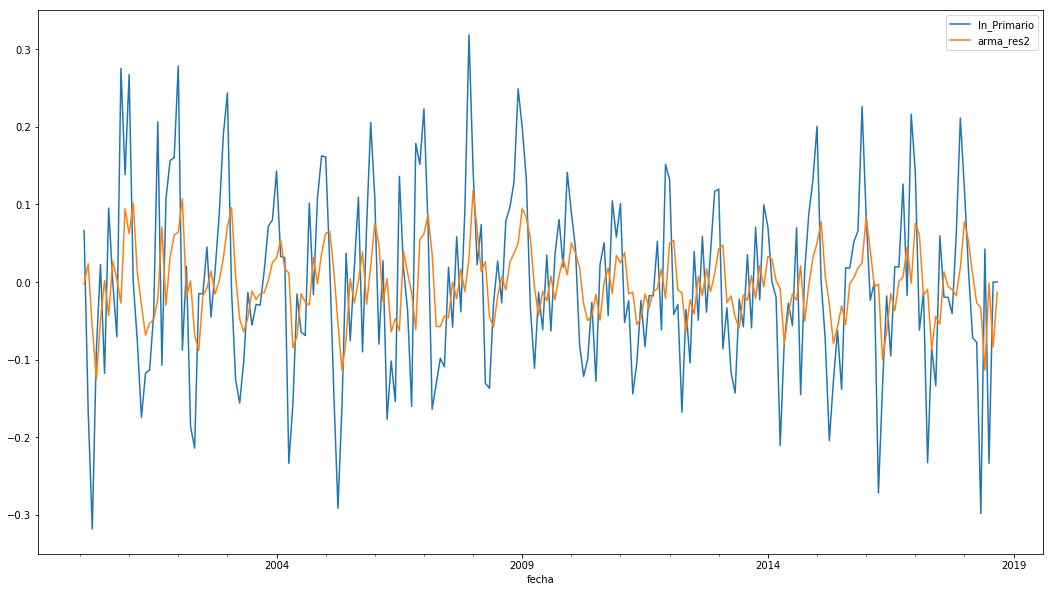

In [31]:
df["arma_res2"]= arma_res2.fittedvalues 
dffit = df[["ln_Primario","arma_res2"]]
dffit.plot(figsize=(18,10))

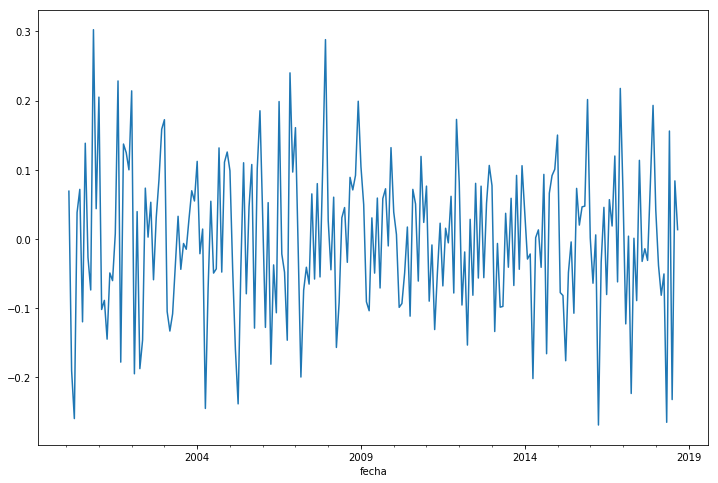

In [32]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax = arma_res2.resid.plot(ax=ax)

In [33]:
resid2 = arma_res2.resid

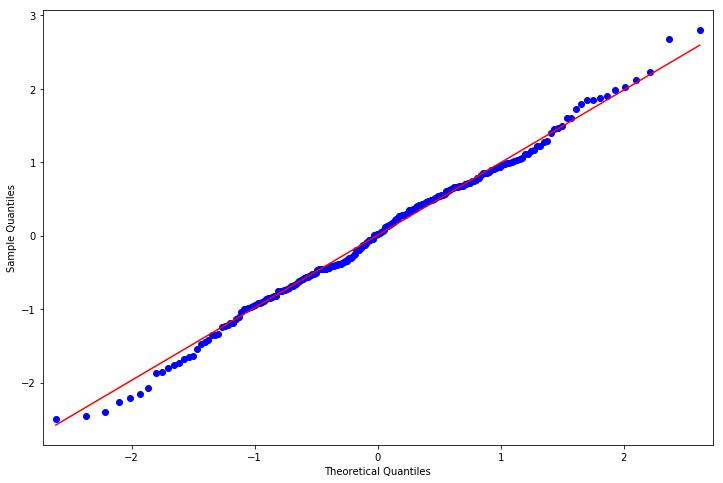

In [34]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(resid2, line='q', ax=ax, fit=True)

Podemos decir que los errores no tiene correlacion 

In [35]:
sm.stats.durbin_watson(arma_res2.resid.values)

1.9725151643770102

In [36]:
stats.normaltest(resid2)

NormaltestResult(statistic=0.049578702995967464, pvalue=0.9755153812404341)

In [44]:
tsa.acorr_ljungbox(arma_res2.resid.values, lags=None, boxpierce=True)

(array([3.71443750e-02, 2.48307886e+00, 4.95852670e+00, 1.89125629e+01,
        2.21398995e+01, 2.64680765e+01, 2.78863930e+01, 4.77458907e+01,
        5.01546040e+01, 5.04916880e+01, 6.94360101e+01, 1.23093622e+02,
        1.35009173e+02, 1.37865817e+02, 1.42853788e+02, 1.55015714e+02,
        1.57567073e+02, 1.60474348e+02, 1.64112351e+02, 1.73655306e+02,
        1.83306760e+02, 1.85666005e+02, 1.93588269e+02, 2.47808466e+02,
        2.60114534e+02, 2.61196948e+02, 2.64070952e+02, 2.77981756e+02,
        2.79498766e+02, 2.81264648e+02, 2.85177043e+02, 2.95962634e+02,
        3.04285117e+02, 3.06027824e+02, 3.17823313e+02, 3.55147758e+02,
        3.66725504e+02, 3.68089105e+02, 3.70899432e+02, 3.81171914e+02]),
 array([8.47171398e-01, 2.88939074e-01, 1.74859335e-01, 8.17648071e-04,
        4.92485224e-04, 1.82093615e-04, 2.30562462e-04, 1.10483904e-07,
        1.00747663e-07, 2.16703163e-07, 1.56350898e-10, 1.49124692e-20,
        2.09678252e-22, 1.88346909e-22, 6.28712741e-23, 7.9849

### Pasemos ahora a la predicción

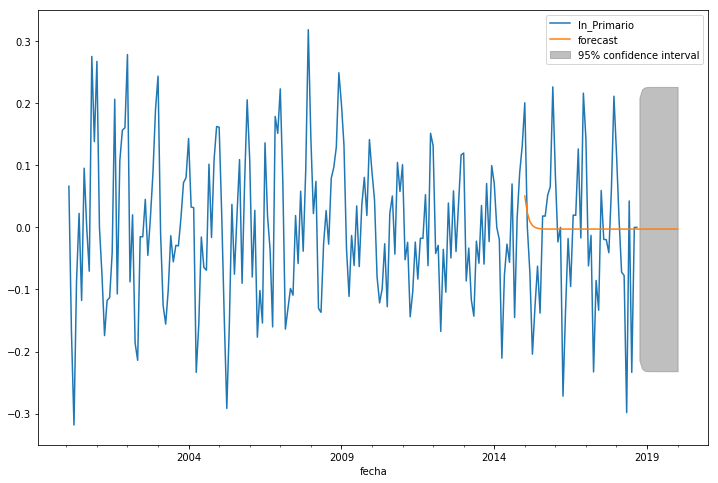

In [37]:
fig, ax = plt.subplots(figsize=(12, 8))
ax = df.ln_Primario.plot(ax=ax)
fig = arma_res2.plot_predict('2015', '2020', dynamic=True, ax=ax, plot_insample=False)

## Filtro Hodrick y Prescott

Separando la tendencia y el ciclo de la serie. De forma que:

<math>$$y_t\ = \tau_t\ + c_t\ + \epsilon_t\,$$</math>

El filtro HP funciona segun la minimizacion de la siguente función cuadratica:
<math>$$\min_{\tau}\left(\sum_{t = 1}^T {(y_t - \tau _t )^2 }  + \lambda \sum_{t = 2}^{T - 1} {[(\tau _{t+1}  - \tau _t) - (\tau _t  - \tau _{t - 1} )]^2 }\right).\,$$</math>

Para ajustar la sensivilidad del filtro se hace mejuate el parameto $\lambda$ que para nuestro caso, el de una serie mensual se ajustaria a 1400. 

In [9]:
cycle, trend = sm.tsa.filters.hpfilter(df.ln_Primario, 14400)


In [10]:
df["ciclo"]= cycle
df["tendencia"]=trend

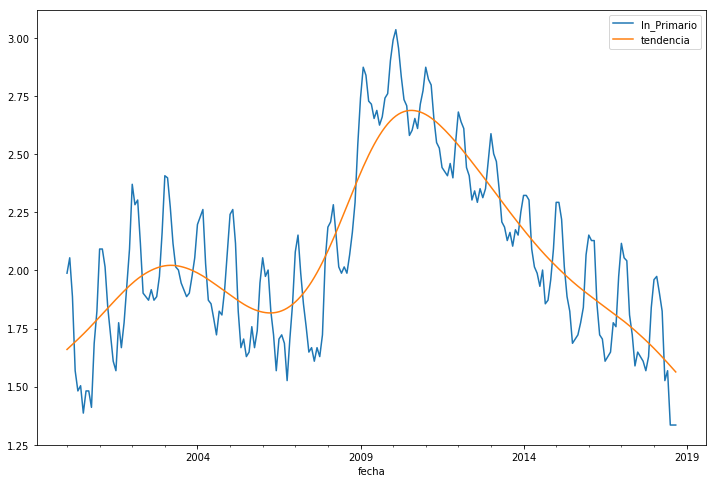

In [13]:
df[["ln_Primario","tendencia"]].plot(figsize=(12,8))                                     


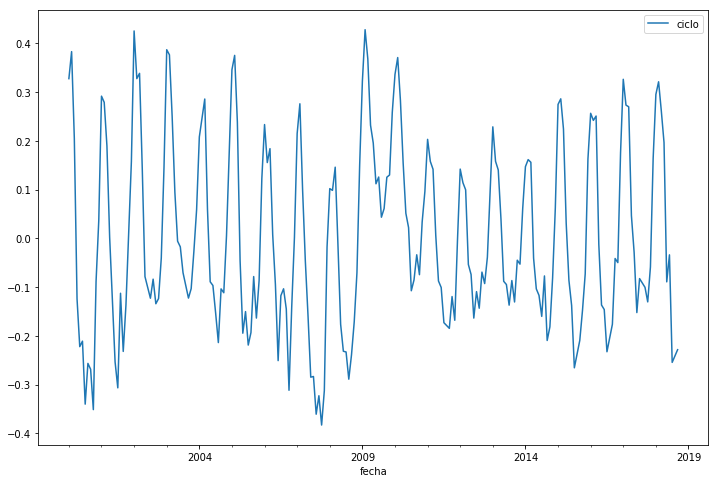

In [15]:
df[["ciclo"]].plot(figsize=(12,8)) 